# Integration with adult Pan-immune data (v2) - Lymphoid

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys,os
import scvi
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scipy

Global seed set to 0


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import scvelo as scv

In [4]:
## import utils
cwd = '../utils/scArches_utils'
sys.path.append(cwd)

import map_query_utils

In [5]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [6]:
%load_ext rpy2.ipython


In [7]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [8]:
def _plot_sorted_violin(merged_adata_bcells, groupby, y_value):
    n_cells_anno = merged_adata_bcells.obs[[groupby,y_value]].value_counts(groupby)
    keep_anno = n_cells_anno.index[n_cells_anno > 30]

    mean_sim = merged_adata_bcells.obs[[groupby,y_value]].groupby(groupby).mean()
    anno_order = mean_sim.loc[keep_anno].sort_values(y_value, ascending=False).index.tolist()

    merged_adata_bcells.var_names_make_unique()
    plt.rcParams["figure.figsize"] = [14,6]
    sc.pl.violin(merged_adata_bcells[merged_adata_bcells.obs[groupby].isin(keep_anno)], 
                                     y_value, groupby=groupby, rotation=90, 
                                     order=anno_order)

In [9]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/fetalVSadult_lymphoid_v2/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir


### Train on scVI models

On GPU node, running the call:

We merge datasets and rerun embeddings running

### Load output

In [10]:
merged_adata_file = 'panimmune_full_LYMPHOID_query.mapped2LYMPHOID.withReference.h5ad'
split = "LYMPHOID"
ref_data_dir = '/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/'
data_dir ="/nfs/team205/ed6/data/Fetal_immune/"

In [11]:
merged_adata = sc.read_h5ad(ref_data_dir + merged_adata_file)

In [13]:
merged_adata

AnnData object with n_obs × n_vars = 506879 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'organ_code', 'donor', 'method', 'Category', 'bbk', 'dataset'
    uns: '_scvi', 'neighbors', 'umap'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [14]:
## Filter maternal contaminants
mat_barcodes = pd.read_csv("~/Pan_fetal_immune/metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
mat_barcodes = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])
reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]
exclude_obs = reference_obs[reference_obs.str.strip("-reference").isin(mat_barcodes)]

merged_adata = merged_adata[~merged_adata.obs_names.isin(exclude_obs)].copy()

In [15]:
## Add metadata and annotations for the reference
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)

## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)
    
reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]
merged_adata.obs["annotation_reference"] = np.nan
merged_adata.obs.loc[reference_obs, "annotation_reference"] = anno_obs.loc[reference_obs.str.strip("-reference")]["anno_lvl_2_final_clean"].values

merged_adata.obs["organ"] = np.nan
merged_adata.obs.loc[reference_obs, "organ"] = anno_obs.loc[reference_obs.str.strip("-reference")]["organ"].values

merged_adata.obs["age"] = np.nan
merged_adata.obs.loc[reference_obs, "age"] = anno_obs.loc[reference_obs.str.strip("-reference")]["age"].values

In [16]:
## Add metadata and annotations for the query
query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
query_anno_obs = merged_adata[query_obs].obs.copy()
merged_adata.obs["annotation_query"] = np.nan
df = query_anno_obs.loc[query_obs][["Category"]].astype("str").replace("nan", np.nan)
merged_adata.obs.loc[query_obs, "annotation_query"] = df["Category"].loc[query_obs].values

# merged_adata.obs["organ_code"] = np.nan
# merged_adata.obs.loc[query_obs, "organ_code"] = query_anno_obs.loc[query_obs.str.strip("-query")]["organ code"].values

saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/fetalVSadult_lymphoid_v2/scvelo_dataset_q2r.png


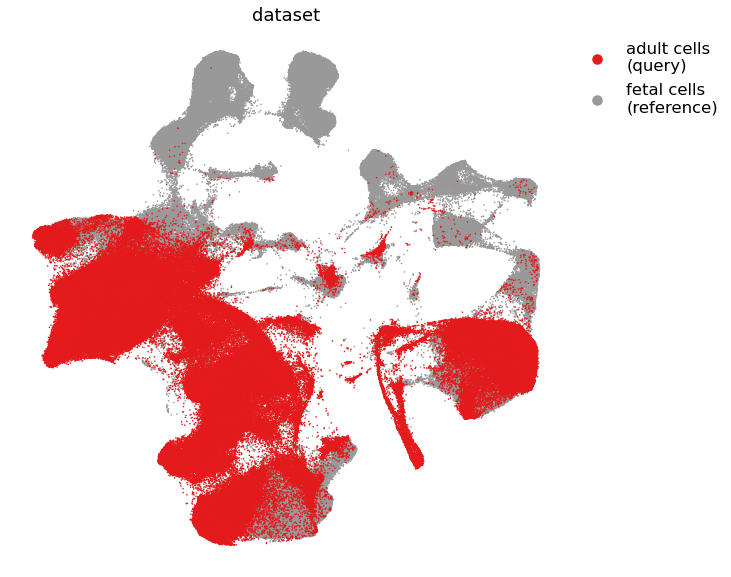

In [254]:
plt.rcParams["figure.figsize"] = [10,10]
merged_adata.obs['dataset_pl'] = ['fetal cells\n(reference)' if x=='reference' else 'adult cells\n(query)' for x in merged_adata.obs['dataset']]
scv.pl.umap(merged_adata, color=["dataset_pl"], size=10, palette='Set1', frameon=False, title='dataset',  
            save="dataset_q2r.png"
           )

Trying to set attribute `.uns` of view, copying.


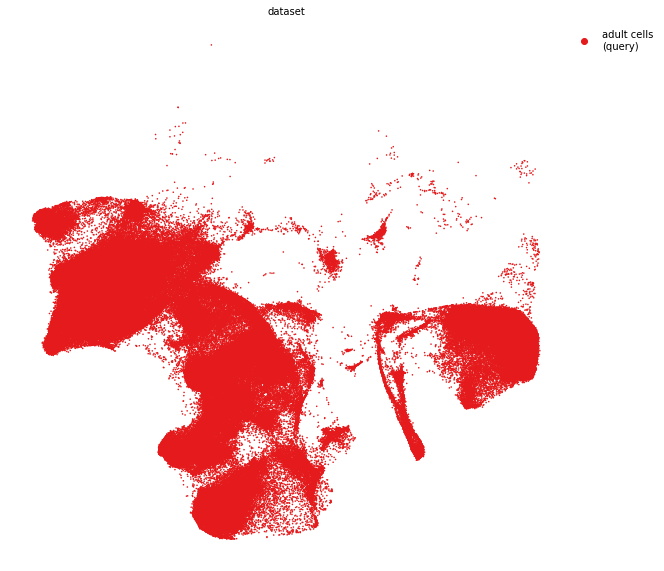

Trying to set attribute `.uns` of view, copying.


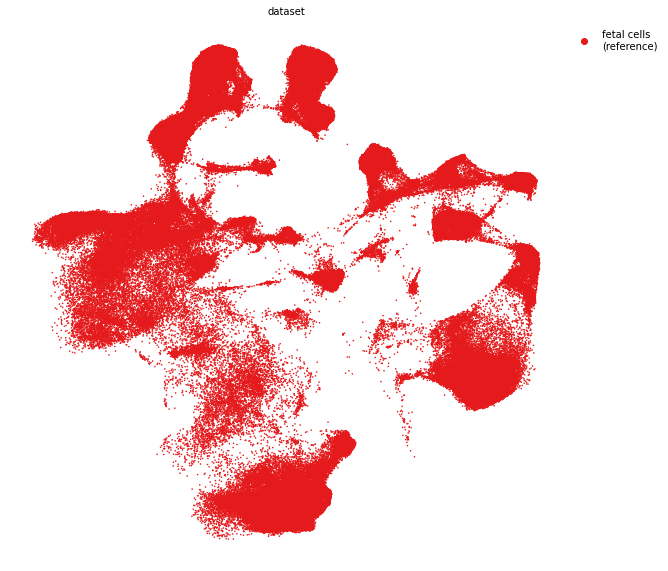

In [17]:
scv.pl.umap(merged_adata[merged_adata.obs['dataset'] == 'query'], color=["dataset_pl"], size=10, palette='Set1', frameon=False, title='dataset',  
#             save="dataset_q2r.pdf"
           )
scv.pl.umap(merged_adata[merged_adata.obs['dataset'] == 'reference'], color=["dataset_pl"], size=10, palette='Set1', frameon=False, title='dataset',  
#             save="dataset_q2r.pdf"
           )

In [18]:
merged_adata.obs["dataset"].value_counts()

query        264929
reference    239698
Name: dataset, dtype: int64

### Plot query and reference annotations

In [242]:
from adjustText import adjust_text
def gen_mpl_labels(
    adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None
):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    medians = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()
        ]
    else:
        texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]

    adjust_text(texts, **adjust_kwargs)

In [19]:
anno_labels_pl = {
#     'Tnaive/CM_CD4_activated':'Tnaive/CM_CD4',
#     'Tem/emra_CD8':'Trm/em_CD8',
#     'Trm_gut_CD8':'Trm/em_CD8',
#     'Tgd_CRTAM+':'Tgd',
#     'Trm_Tgd':'Tgd',
    'GC_B (I)':'GC B',
    'GC_B (II)':'GC B'
}

plt.rcParams['figure.figsize'] = [12,12]
merged_adata.obs["annotation_query_pl"] = [anno_labels_pl[x] if x in anno_labels_pl.keys() else x for x in merged_adata.obs["annotation_query"]]
label_counts = merged_adata.obs["annotation_query_pl"].value_counts()
anno_labels = label_counts.index[label_counts > 10]

In [20]:
merged_adata.obs[merged_adata.obs['dataset']=='query']

,n_counts,n_genes,file,mito,doublet_scores,predicted_doublets,name,organ_code,donor,method,Category,bbk,dataset,annotation_reference,organ,age,annotation_query,dataset_pl,annotation_query_pl
Pan_T7935490_AAACCTGCAAATTGCC-query,NaN,NaN,nan,NaN,NaN,nan,nan,ILE,A29,5GEX,Trm_Th1/Th17,5GEXA29,query,NaN,NaN,NaN,Trm_Th1/Th17,adult cells\n(query),Trm_Th1/Th17
Pan_T7935490_AAACGGGCATCTGGTA-query,NaN,NaN,nan,NaN,NaN,nan,nan,ILE,A29,5GEX,Trm_gut_CD8,5GEXA29,query,NaN,NaN,NaN,Trm_gut_CD8,adult cells\n(query),Trm_gut_CD8
Pan_T7935490_AAACGGGTCTTGCATT-query,NaN,NaN,nan,NaN,NaN,nan,nan,ILE,A29,5GEX,Trm_gut_CD8,5GEXA29,query,NaN,NaN,NaN,Trm_gut_CD8,adult cells\n(query),Trm_gut_CD8
Pan_T7935490_AAAGCAATCATCGCTC-query,NaN,NaN,nan,NaN,NaN,nan,nan,ILE,A29,5GEX,Trm_gut_CD8,5GEXA29,query,NaN,NaN,NaN,Trm_gut_CD8,adult cells\n(query),Trm_gut_CD8
Pan_T7935490_AAAGTAGCAGTCACTA-query,NaN,NaN,nan,NaN,NaN,nan,nan,ILE,A29,5GEX,Trm_Tgd,5GEXA29,query,NaN,NaN,NaN,Trm_Tgd,adult cells\n(query),Trm_Tgd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CZINY-0112_TTTGGTTAGGCCACTC-query,NaN,NaN,nan,NaN,NaN,nan,nan,JEJEPI,D496,3GEX,Trm_gut_CD8,3GEXD496,query,NaN,NaN,NaN,Trm_gut_CD8,adult cells\n(query),Trm_gut_CD8
CZINY-0112_TTTGGTTCACAAAGTA-query,NaN,NaN,nan,NaN,NaN,nan,nan,SPL,D496,3GEX,Tfh,3GEXD496,query,NaN,NaN,NaN,Tfh,adult cells\n(query),Tfh
CZINY-0112_TTTGGTTTCCATCACC-query,NaN,NaN,nan,NaN,NaN,nan,nan,LNG,D496,3GEX,Tem/emra_CD8,3GEXD496,query,NaN,NaN,NaN,Tem/emra_CD8,adult cells\n(query),Tem/emra_CD8
CZINY-0112_TTTGTTGCAGCGGTTC-query,NaN,NaN,nan,NaN,NaN,nan,nan,SPL,D496,3GEX,Tfh,3GEXD496,query,NaN,NaN,NaN,Tfh,adult cells\n(query),Tfh


saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/fetalVSadult_lymphoid_v2/scvelo_anno_query.png


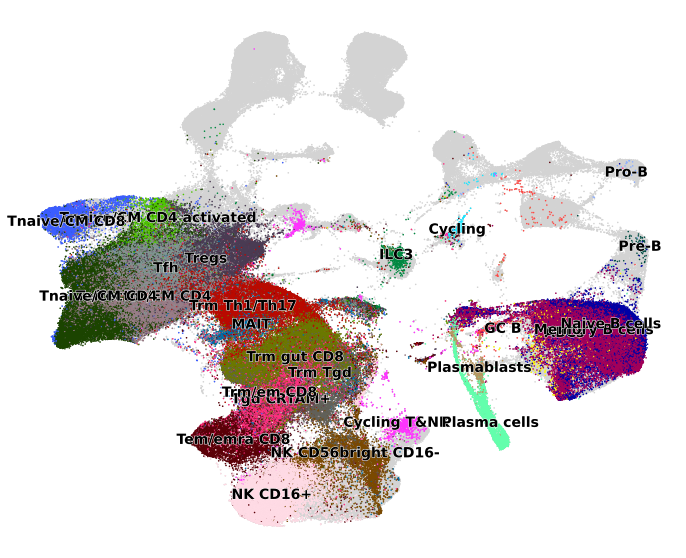

In [238]:
scv.pl.umap(merged_adata, color=["annotation_query_pl"], 
            size=10, 
            palette=sc.pl.palettes.godsnot_102,
            legend_loc="on data",  title="", 
            legend_fontsize=14, 
            save="anno_query.png"
           )

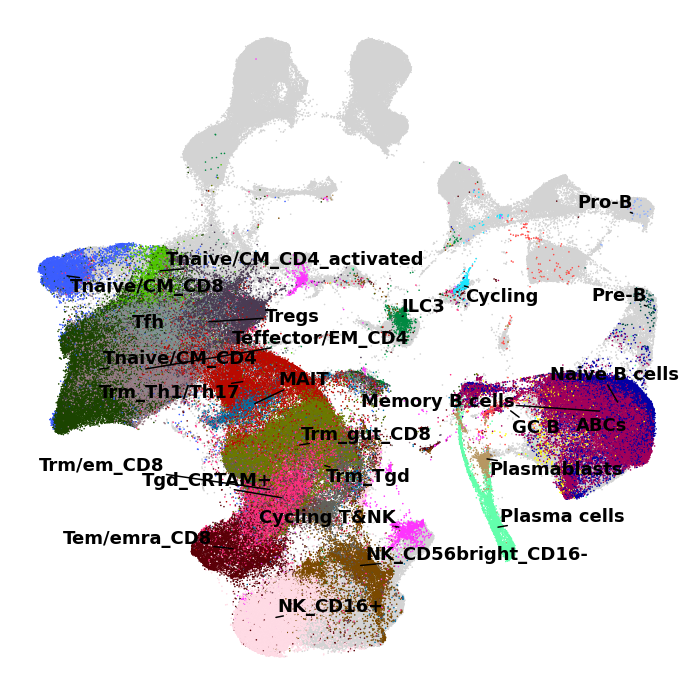

In [267]:
ax = sc.pl.umap(merged_adata, color=["annotation_query_pl"], 
            size=10, 
            palette=sc.pl.palettes.godsnot_102,
            legend_fontsize=14, frameon=False,
            title="", show=False, legend_loc=None)
gen_mpl_labels(
    merged_adata,
    "annotation_query_pl",
    exclude=merged_adata.obs['annotation_reference'][~merged_adata.obs['annotation_reference'].isin(anno_labels)].unique().tolist(),
    ax=ax,
    adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
    text_kwargs=dict(fontsize=18, fontweight='bold'),
)
fig = ax.get_figure()
fig.tight_layout()
plt.savefig(figdir+"anno_query_fixedlabels.png")

saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/fetalVSadult_lymphoid_v2/scvelo_anno_reference.png


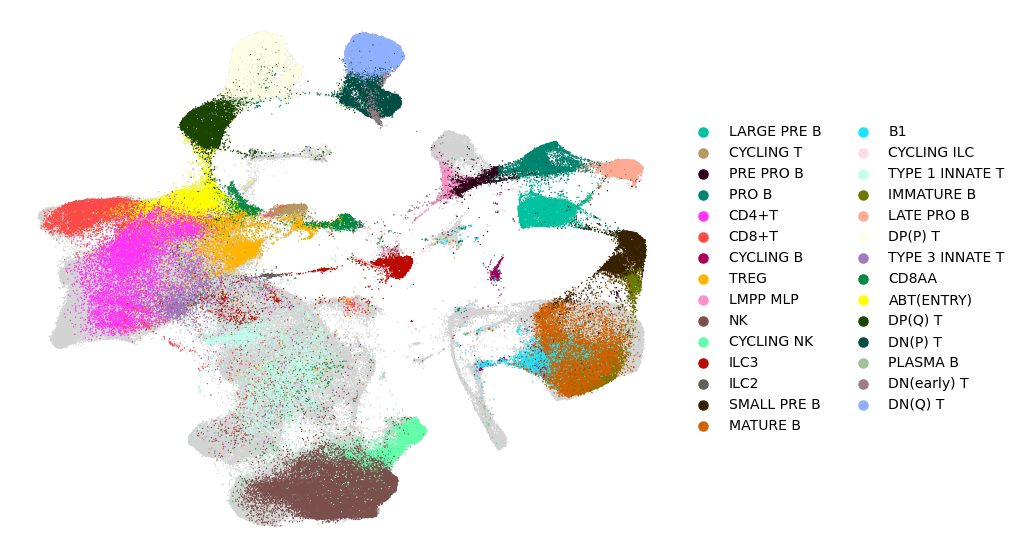

In [240]:
anno_labels = merged_adata.obs["annotation_reference"][merged_adata.obs["annotation_reference"]!="nan"].unique().tolist()
anno_labels = [x for x in anno_labels if type(x)==str]
anno_labels = [x for x in anno_labels if x not in anno_groups_dict["OTHER"]]
anno_labels = [x for x in anno_labels if x not in anno_groups_dict["PROGENITORS"]]
anno_labels = [x for x in anno_labels if sum(merged_adata.obs['annotation_reference'] == x) > 30]

scv.pl.umap(merged_adata, color=["annotation_reference"], size=7, legend_loc="right margin", groups=anno_labels, 
            legend_fontsize=14,
            title="",
           save="anno_reference.png"
           )



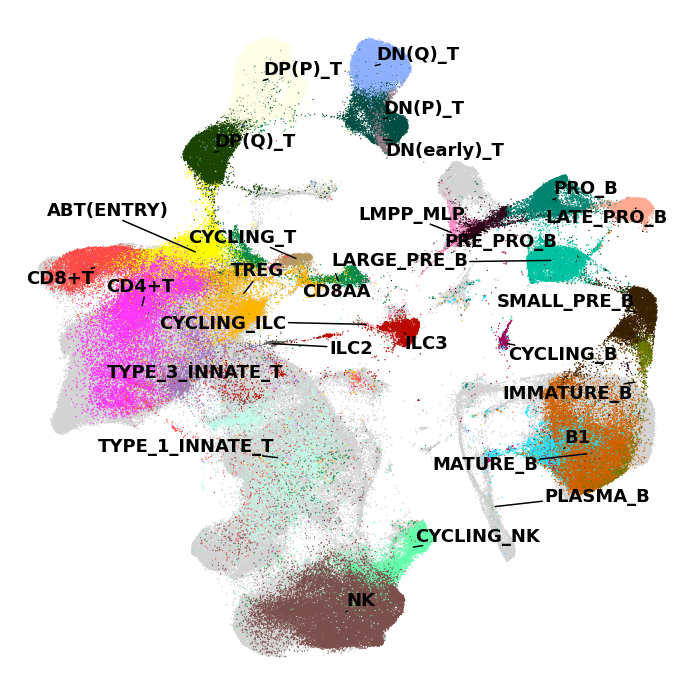

In [268]:
ax = sc.pl.umap(merged_adata, color=["annotation_reference"], size=7, groups=anno_labels, frameon=False,
            legend_fontsize=14,
            title="", show=False, legend_loc=None)
gen_mpl_labels(
    merged_adata,
    "annotation_reference",
    exclude=merged_adata.obs['annotation_reference'][~merged_adata.obs['annotation_reference'].isin(anno_labels)].unique().tolist(),
    ax=ax,
    adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
    text_kwargs=dict(fontsize=18, fontweight='bold'),
)
fig = ax.get_figure()
fig.tight_layout()
plt.savefig(figdir+"anno_reference_fixedlabels.png")

In [ ]:
def _compute_invivoVSinvitro_distance(merged_adata, 
                                      q_cl, ## query cluster
                                      r_cl, ## reference cluster
                                      q_obs = 'annotation_query',
                                      r_obs = 'annotation_reference',
                                     ):
    keep_invitro_cells = (merged_adata.obs['dataset'] == 'query') & (merged_adata.obs[q_obs] == q_cl)
    keep_invivo_cells = (merged_adata.obs['dataset'] == 'reference') & (merged_adata.obs[r_obs] == r_cl)

    X_dims = merged_adata.obsm['X_scvi'].copy()
    X_dims_invivo = X_dims[keep_invivo_cells,:]
    X_dims_invitro = X_dims[keep_invitro_cells,:]
    dmat = scipy.spatial.distance.cdist( X_dims_invitro, X_dims_invivo, metric='euclidean')
    min_dist = np.min(dmat, 1)
    min_dist = map_query_utils._scArches_adjusted_dist(min_dist)
    min_dist_df = pd.DataFrame(min_dist, columns=['min_dist'])
    min_dist_df['ref_population'] = r_cl
    min_dist_df['query_population'] = q_cl 
    min_dist_df['cell_barcode'] = merged_adata.obs_names[keep_invitro_cells]
    return(min_dist_df)

def _compute_within_distance(merged_adata, 
                                      q_cl, ## query cluster
                                      q_obs = 'annotation_query',
                                     ):
    keep_invitro_cells = (merged_adata.obs['dataset'] == 'query') & (merged_adata.obs[q_obs] == q_cl)
    X_dims = merged_adata.obsm['X_scvi'].copy()
    X_dims_invitro = X_dims[keep_invitro_cells,:]
    mean_dist = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(X_dims_invitro, metric='cosine')).min()
    return(mean_dist)

ref_cts = anno_groups_dict['NK/T CELLS']
que_cts = merged_adata.obs["annotation_query"].unique().dropna()

ct_distances_df = pd.DataFrame()
for r in ref_cts:
    for q in que_cts:
        d = _compute_invivoVSinvitro_distance(merged_adata, q_cl=q, r_cl=r)
        ct_distances_df = pd.concat([ct_distances_df, d])

In [ ]:
df = ct_distances_df[ct_distances_df['ref_population'].isin(['TREG', 'TYPE_1_INNATE_T', 'TYPE_3_INNATE_T', "CD4+T"])]

mean_dist_df = df.groupby(['ref_population', 'query_population']).mean().reset_index()
mean_dist_df['sd_min_dist'] = df.groupby(['ref_population', 'query_population']).std().reset_index()['min_dist']
mean_dist_df

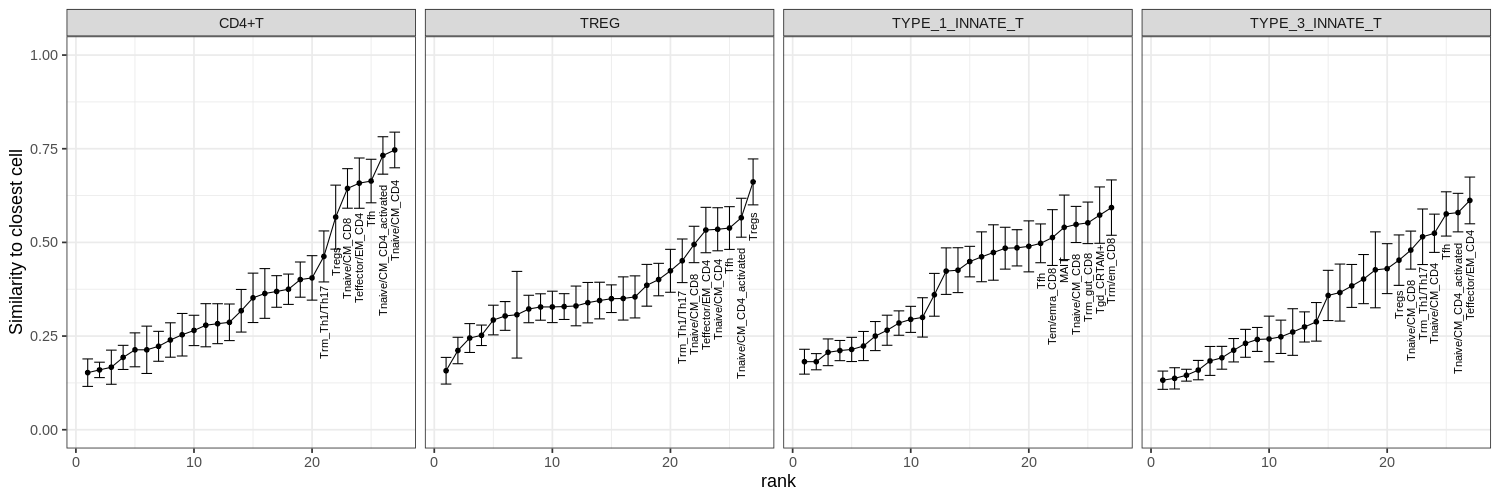

In [252]:
%%R -w 1500 -h 500 -i mean_dist_df
mean_dist_df %>% 
group_by(ref_population) %>%
mutate(rank = rank(min_dist)) %>%
ungroup() %>%
ggplot(aes(rank, min_dist)) +
geom_point(size=2) +
geom_line() +
geom_errorbar(aes(ymin=min_dist-(sd_min_dist), ymax=min_dist+(sd_min_dist))) +
geom_text(data = . %>% filter(rank> 20), aes(label=query_population), nudge_y=-0.08, hjust = 1, angle=90) +
# geom_boxplot() +
# coord_flip() +
facet_wrap(ref_population~., ncol=4) +
ylim(0,1) +
theme_bw(base_size=18) +
ylab("Similarity to closest cell") 

### Transfer labels

In [15]:
# # min_ref_neighbors = adata.uns["neighbors"]["params"]["n_neighbors"]/10
# missing_anno = merged_adata.obs["dataset"] == "query"

# ## Find neighbors of cells with conflicting annotation
# knn_graph = merged_adata.obsp['distances']
# knn_graph_query = knn_graph[missing_anno,:]
# # knn_graph_query[knn_graph_query.nonzero()] = 1

In [70]:
def predict_label2(merged_adata, anno_col = 'annotation_reference', k=50, min_score = 0.5):
    '''
    Predict annotation labels for query cells based on k-NNs in the reference data
    '''
    import time
    from scipy.spatial import cKDTree

    ## Extract embedding
    X_emb = merged_adata.obsm["X_scvi"].copy()

    is_query = merged_adata.obs["dataset"] == "query"
    is_reference = merged_adata.obs["dataset"] == "reference"

    X_emb_ref = X_emb[is_reference,:]
    X_emb_que = X_emb[is_query,:]

    ## Find nearest neighbors in reference
    k1=k2=k
    data_query = X_emb_que
    data_ref = X_emb_ref
    start = time.time()
    k_index_ref = cKDTree(data_ref).query(x=data_query, k=k1, n_jobs=5)[1]
    end = time.time()
    print(end - start)

    knn_mat = np.zeros(shape=[sum(is_query),sum(is_reference)])
    for i in range(k_index_ref.shape[0]):
        knn_mat[i, k_index_ref[i]] = 1

    ## Subset to reference cells that have are NN to at least one query cell
    keep_ref_ixs = np.unique(k_index_ref.ravel())
    keep_ref_ixs.sort()
    small_knn_mat = knn_mat[:,keep_ref_ixs]

    ## Make dummy matrix of annotations
    annos = merged_adata[is_reference].obs[anno_col][keep_ref_ixs].copy()
    dummy_df = pd.get_dummies(annos)
    dummy_mat = dummy_df.values

    ## Sum number of neighbors with each annotation
    new_anno = small_knn_mat.dot(dummy_mat)

    ## Find top scorers
    n_neighbors = np.array(small_knn_mat.sum(1)).flatten()
    n_neighbors_ref = new_anno.sum(axis=1)
    new_anno_prob = new_anno.T/n_neighbors_ref
    new_anno_prob[np.isnan(new_anno_prob)] = 0
    best_label = dummy_df.columns[new_anno_prob.argmax(0)].values
    best_label_score = new_anno_prob.max(0)
    best_label = best_label.astype('str')

    ## Call low confidence if probability is < min_score
    best_label_all = best_label.copy()
    best_label[best_label_score <= min_score] = "low_confidence"

    ## Save output in place
    del merged_adata.obs['predicted_anno'] 
    merged_adata.obs['predicted_anno'] = np.nan
    merged_adata.obs['predicted_anno_unfiltered'] = np.nan
    merged_adata.obs['predicted_anno_prob'] = np.nan
    merged_adata.obs.loc[is_query,'predicted_anno'] = best_label
    merged_adata.obs.loc[is_query,'predicted_anno_unfiltered'] = best_label_all
    merged_adata.obs.loc[is_query,'predicted_anno_prob'] = best_label_score

In [71]:
merged_adata.obs["annotation_reference"] = merged_adata.obs["annotation_reference"].astype("str").replace("nan", np.nan)
if 'predicted_anno' in merged_adata.obs.columns:
    merged_adata.obs.drop('predicted_anno', 1, inplace=True)

## Split query cells in batches (avoid eating all the RAM)
n_batches = 10
q_obs = merged_adata.obs_names[merged_adata.obs['dataset'] == 'query']
r_obs = merged_adata.obs_names[merged_adata.obs['dataset'] == 'reference']
b_size = q_obs.shape[0]//10

for c in ['predicted_anno', 'predicted_anno_unfiltered', 'predicted_anno_prob']:
    merged_adata.obs[c] = np.nan

i = 0
while i < q_obs.shape[0]:
    b_obs = q_obs[i:(i+b_size)]
    i += b_size
    
    ## Split query cells in batches (avoid eating all the RAM)
    b_merged_adata = merged_adata[r_obs.tolist() + b_obs.tolist()].copy()
    map_query_utils.predict_label2(b_merged_adata, anno_col="annotation_reference", k=100)

    for c in ['predicted_anno', 'predicted_anno_unfiltered', 'predicted_anno_prob']:
        merged_adata.obs.loc[b_obs,c] = b_merged_adata.obs.loc[b_obs,c]

25.238778352737427
18.47018074989319
26.02779197692871
19.595580577850342
28.226304054260254
28.838073253631592
19.244407892227173
19.00939154624939
18.373257398605347
18.761417150497437
0.24323534965515137


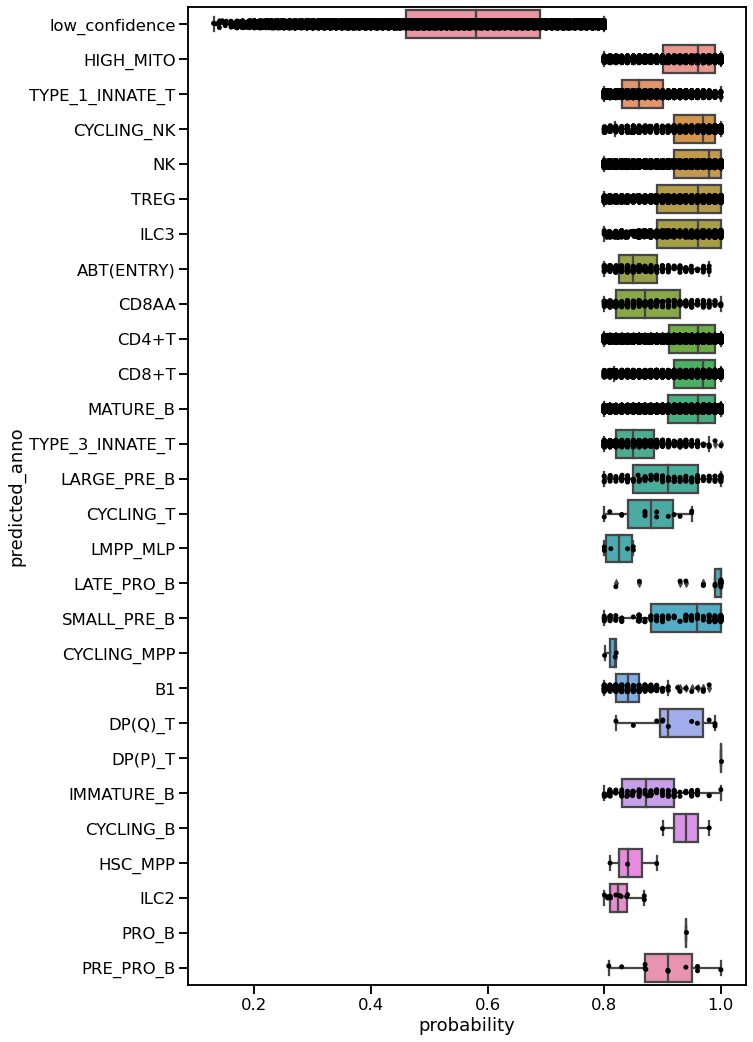

In [79]:
plt.rcParams["figure.figsize"] = [10,18]
map_query_utils.plot_predicted_anno_probability(merged_adata)

In [80]:
merged_adata.obs.loc[merged_adata.obs['predicted_anno_prob'] < 0.8, 'predicted_anno'] = 'low_confidence'

In [81]:
sns.set_context("talk")
query_anno_col="annotation_query"

query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
empty_query = query_obs[merged_adata[query_obs].obs[query_anno_col]=="nan"]
merged_adata_clean = merged_adata[~merged_adata.obs_names.isin(empty_query)].copy()
merged_adata_clean.obs[query_anno_col] = merged_adata_clean.obs[query_anno_col].astype("str")

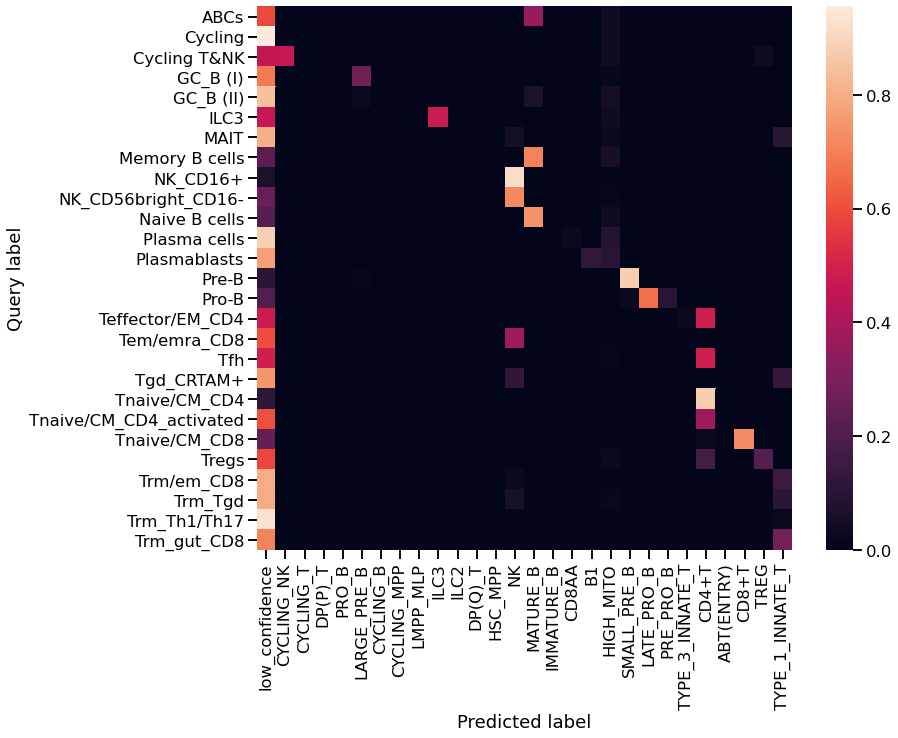

In [82]:
plt.rcParams["figure.figsize"] = [12,10]
map_query_utils.plot_confusion_mat(merged_adata_clean, query_anno_col=query_anno_col, show_low_confidence=True)

In [65]:
merged_adata.write_h5ad(data_dir + merged_adata_file)

... storing 'annotation_reference' as categorical
... storing 'predicted_anno_unfiltered' as categorical
... storing 'predicted_anno' as categorical


In [11]:
merged_adata = sc.read_h5ad(data_dir + merged_adata_file)

### Quantify matching between datasets

In [66]:
import time
## Calculate distance of a query cell to closest cell of 
# predicted annotation

def _compute_min_dist2predicted_anno(merged_adata, r_cl,
#                                      q_cell,
                                     r_obs = 'annotation_reference',
                                     pred_anno_obs = 'predicted_anno_unfiltered'
                                    ):
    from scipy.spatial import cKDTree
    # Pick reference cluster 
    keep_ref_cells = (merged_adata.obs['dataset'] == 'reference') & (merged_adata.obs[r_obs] == r_cl)
    keep_query_cells = (merged_adata.obs['dataset'] == 'query') & (merged_adata.obs[pred_anno_obs] == r_cl)

    ## Calculate distance of query cell to all reference
    # cells in cluster
    X_dims = merged_adata.obsm['X_scvi'].copy()
    X_dims_invivo = X_dims[keep_ref_cells,:]
    X_dims_invitro = X_dims[keep_query_cells,:]
    k_ref = cKDTree(X_dims_invivo).query(x=X_dims_invitro, k=1, n_jobs=5)
    min_dists = k_ref[0]
    min_dists_df = pd.DataFrame(zip(merged_adata.obs_names[keep_query_cells],min_dists), columns=['query_cell', 'min_distance2pred'])
    return(min_dists_df)

start = time.time()
merged_adata.obs['min_distance2pred'] = np.nan
counter = 0
is_query = merged_adata.obs["dataset"] == "query"
is_reference = merged_adata.obs["dataset"] == "reference"
for r_cl in merged_adata.obs['predicted_anno_unfiltered'].unique():
    counter += 1
    min_dists_df = _compute_min_dist2predicted_anno(merged_adata, r_cl)
    merged_adata.obs.loc[min_dists_df.query_cell, 'min_distance2pred'] = min_dists_df.min_distance2pred.values
    print(counter)
## Normalize w gaussian kernel
merged_adata.obs.loc[is_query, 'min_distance2pred'] = map_query_utils._scArches_adjusted_dist(merged_adata.obs.loc[is_query, 'min_distance2pred'].astype('float').values)
end = time.time()
print(end-start)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
10.654104948043823


In [67]:
merged_adata.obs

,n_counts,n_genes,file,mito,doublet_scores,predicted_doublets,name,organ_code,donor,method,...,annotation_reference,organ,age,annotation_query,dataset_pl,annotation_query_pl,predicted_anno_unfiltered,predicted_anno_prob,predicted_anno,min_distance2pred
FCAImmP7579224-CTAATGGCACTGTGTA-reference,51305.0,5492.0,FCAImmP7579224,0.046467,0.176471,False,FCAImmP7579224_filtered.h5ad,nan,nan,nan,...,LARGE_PRE_B,SK,12.0,NaN,fetal cells\n(reference),NaN,NaN,NaN,NaN,NaN
FCAImmP7579224-ATTATCCAGAGAACAG-reference,39999.0,5076.0,FCAImmP7579224,0.038651,0.087221,False,FCAImmP7579224_filtered.h5ad,nan,nan,nan,...,LOW_Q_INCONSISTENT,SK,12.0,NaN,fetal cells\n(reference),NaN,NaN,NaN,NaN,NaN
FCAImmP7579224-GACGGCTAGCCACCTG-reference,38114.0,5282.0,FCAImmP7579224,0.034633,0.110588,False,FCAImmP7579224_filtered.h5ad,nan,nan,nan,...,CYCLING_T,SK,12.0,NaN,fetal cells\n(reference),NaN,NaN,NaN,NaN,NaN
FCAImmP7579224-GCGGGTTGTCCGAGTC-reference,33207.0,4690.0,FCAImmP7579224,0.028247,0.133690,False,FCAImmP7579224_filtered.h5ad,nan,nan,nan,...,CYCLING_T,SK,12.0,NaN,fetal cells\n(reference),NaN,NaN,NaN,NaN,NaN
FCAImmP7579224-AGTTGGTAGTGTTAGA-reference,31058.0,4591.0,FCAImmP7579224,0.044433,0.133690,False,FCAImmP7579224_filtered.h5ad,nan,nan,nan,...,CYCLING_T,SK,12.0,NaN,fetal cells\n(reference),NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CZINY-0112_TTTGGTTAGGCCACTC-query,NaN,NaN,nan,NaN,NaN,nan,nan,JEJEPI,D496,3GEX,...,NaN,NaN,NaN,Trm_gut_CD8,adult cells\n(query),Trm_gut_CD8,TYPE_1_INNATE_T,0.484375,low_confidence,0.742058
CZINY-0112_TTTGGTTCACAAAGTA-query,NaN,NaN,nan,NaN,NaN,nan,nan,SPL,D496,3GEX,...,NaN,NaN,NaN,Tfh,adult cells\n(query),Tfh,CD4+T,0.540541,low_confidence,0.757596
CZINY-0112_TTTGGTTTCCATCACC-query,NaN,NaN,nan,NaN,NaN,nan,nan,LNG,D496,3GEX,...,NaN,NaN,NaN,Tem/emra_CD8,adult cells\n(query),Tem/emra_CD8,NK,0.790698,low_confidence,0.721071
CZINY-0112_TTTGTTGCAGCGGTTC-query,NaN,NaN,nan,NaN,NaN,nan,nan,SPL,D496,3GEX,...,NaN,NaN,NaN,Tfh,adult cells\n(query),Tfh,CD4+T,0.829787,CD4+T,0.73521


### Combined similarity & confusion matrix

In [215]:
q_df = merged_adata[merged_adata.obs['dataset'] == 'query'].obs[["min_distance2pred", "predicted_anno", "annotation_query", 'organ_code']]
q_df = q_df[~q_df.annotation_query.isna()]
q_df.annotation_query = q_df.annotation_query.astype('str')
q_df.min_distance2pred = q_df.min_distance2pred.astype('float')

In [216]:
query_anno_group_lymphoid = {
    "B cells":[x for x in q_df.annotation_query.unique() if x.endswith("B cells") or x.endswith("B") or "GC_B" in x or x=="B_prog" or "Plasma" in x or x=='ABCs'],
    "NK cells":[x for x in q_df.annotation_query.unique() if x.startswith("NK")],
    "other":[x for x in q_df.annotation_query.unique() if 'doublets' in x],
    }

query_anno_group_lymphoid['T cells'] = [x for x in q_df.annotation_query.unique() if x not in sum(query_anno_group_lymphoid.values(),[])]
query_anno_group_lymphoid_rev = {x:g for g,a in query_anno_group_lymphoid.items() for x in a}

ref_anno_group_lymphoid = {
    "NK cells":[x for x in q_df.predicted_anno.unique() if x.endswith("NK")],
    "ILCs":[x for x in q_df.predicted_anno.unique() if x.startswith("ILC")],
    "B cells":[x for x in q_df.predicted_anno.unique() if x.endswith("B") or x=="B1"],
    "T cells":[x for x in q_df.predicted_anno.unique() if x.endswith("T") or x=="ABT(ENTRY)" or x=="CD8AA" or x=="TREG"],
    'low_confidence':['low_confidence']
    }

ref_anno_group_lymphoid['other'] = [x for x in q_df.predicted_anno.unique() if x not in sum(ref_anno_group_lymphoid.values(),[])]
ref_anno_group_lymphoid_rev = {x:g for g,a in ref_anno_group_lymphoid.items() for x in a}

q_df['annotation_query_group'] = [query_anno_group_lymphoid_rev[x] for x in q_df['annotation_query']]
q_df['predicted_anno_group'] = [ref_anno_group_lymphoid_rev[x] for x in q_df['predicted_anno']]

In [223]:
order_ref_anno = [
    'CYCLING_NK', 'NK', 'ILC3', 'ILC2', 
     'PRE_PRO_B','PRO_B',  'LATE_PRO_B', 'SMALL_PRE_B','LARGE_PRE_B',  'IMMATURE_B','MATURE_B','B1',  'CYCLING_B', 
    'DP(Q)_T', 'DP(P)_T', 'ABT(ENTRY)', 'CD8AA',  'CD4+T', 'CD8+T', 'TREG','TYPE_1_INNATE_T',  'TYPE_3_INNATE_T', 'CYCLING_T',  'low_confidence', 'HIGH_MITO', 'LMPP_MLP', 'CYCLING_MPP', 'HSC_MPP']

In [225]:
order_que_anno = [
     'Pro-B', 'Pre-B', 'Memory B cells', 'Naive B cells', 'ABCs', 'GC_B (I)', 'GC_B (II)', 'Plasmablasts','Plasma cells',
    'NK_CD16+', 'NK_CD56bright_CD16-', 'ILC3',
    'Tnaive/CM_CD4','Tnaive/CM_CD4_activated','Teffector/EM_CD4', 'Tnaive/CM_CD8','Trm/em_CD8','Tem/emra_CD8',  'Trm_gut_CD8','Cycling T&NK', 'Tregs',   'Trm_Th1/Th17','Tfh', 'Trm_Tgd', 'Tgd_CRTAM+','MAIT', 'Cycling']

In [231]:
%%R -i q_df -h 800 -w 1200 -i figdir -i order_que_anno -i order_ref_anno
pl_q_df <- q_df %>%
    group_by(annotation_query) %>%
    mutate(tot_cells=n()) %>%
    ungroup() %>%
    group_by(predicted_anno, annotation_query, annotation_query_group, predicted_anno_group) %>%
    summarise(frac_cells=n()/tot_cells, median_sim_score=median(min_distance2pred)) %>%
    ungroup() %>%
    filter(annotation_query_group != 'other' & predicted_anno_group != 'other' ) %>%
    mutate(annotation_query_group=factor(annotation_query_group, levels=c('NK cells', 'ILCs', 'B cells', 'T cells'))) %>%
    mutate(predicted_anno_group = ifelse(predicted_anno_group=="low_confidence", '', predicted_anno_group)) %>%
    mutate(predicted_anno_group=factor(predicted_anno_group, levels=c('NK cells', 'ILCs', 'B cells', 'T cells', ''))) %>%
    mutate(predicted_anno=factor(predicted_anno, levels=order_ref_anno)) %>%
    mutate(annotation_query=factor(annotation_query, levels=rev(order_que_anno)))

`summarise()` has grouped output by 'predicted_anno', 'annotation_query', 'annotation_query_group', 'predicted_anno_group'. You can override using the `.groups` argument.


In [261]:
%%R
pl_q_df %>%
head() %>%
distinct()

  predicted_anno annotation_query annotation_query_group predicted_anno_group
1     ABT(ENTRY) Teffector/EM_CD4                T cells              T cells
2     ABT(ENTRY)              Tfh                T cells              T cells
   frac_cells median_sim_score
1 0.000150989        0.7448054
2 0.006931276        0.7460693


In [262]:
%%R -h 800 -w 1200 -i figdir
pl <- pl_q_df %>%
    distinct() %>%
    ggplot(aes(predicted_anno, annotation_query)) +
    scale_size(range=c(1,8), name="Fraction\nof cells") +
    geom_point(aes(size=frac_cells, fill=median_sim_score), shape=21) +
    scale_fill_distiller(palette="Spectral", direction=-1, name='Median\nsimilarity',
                        ) +
#     scale_fill_viridis_c(option='magma', name='Median\nsimilarity') +
    facet_grid(annotation_query_group~predicted_anno_group, space="free", scales='free') +
    xlab("Predicted fetal cell type") + ylab("Adult cell type") +
    theme_bw(base_size=22) +
    theme(axis.text.x=element_text(angle=45, hjust=1),
          strip.text.y=element_text(angle=0), strip.text.x=element_text(angle=90)
         ) +

    ggsave(paste0(figdir, "adult_confusion_similarity_dotplot.pdf"), width=17, height=15) 

In [233]:
## Save for future plotting
q_df.to_csv('/nfs/team205/ed6/data/Fetal_immune/panimmune_full_LYMPHOID_query.mapped2LYMPHOID.v2.confusion_table.csv')

### Check CD4+T EM cells

In [94]:
## Subset to query cells and CD4+ fetal T cells
smp_merged_adata = merged_adata[(merged_adata.obs['dataset'] == 'query') | (merged_adata.obs['annotation_reference'] == 'CD4+T')].copy()

In [96]:
smp_merged_adata_rev = smp_merged_adata.copy()
smp_merged_adata_rev.obs['dataset'] = ['reference' if x=='query' else 'query' for x in smp_merged_adata_rev.obs['dataset']]

In [97]:
smp_merged_adata_rev.obs["annotation_reference"] = smp_merged_adata.obs["annotation_reference"].astype("str").replace("nan", np.nan)
if 'predicted_anno' in smp_merged_adata_rev.obs.columns:
    smp_merged_adata_rev.obs.drop('predicted_anno', 1, inplace=True)
map_query_utils.predict_label2(smp_merged_adata_rev, anno_col="annotation_query")

10.02190089225769


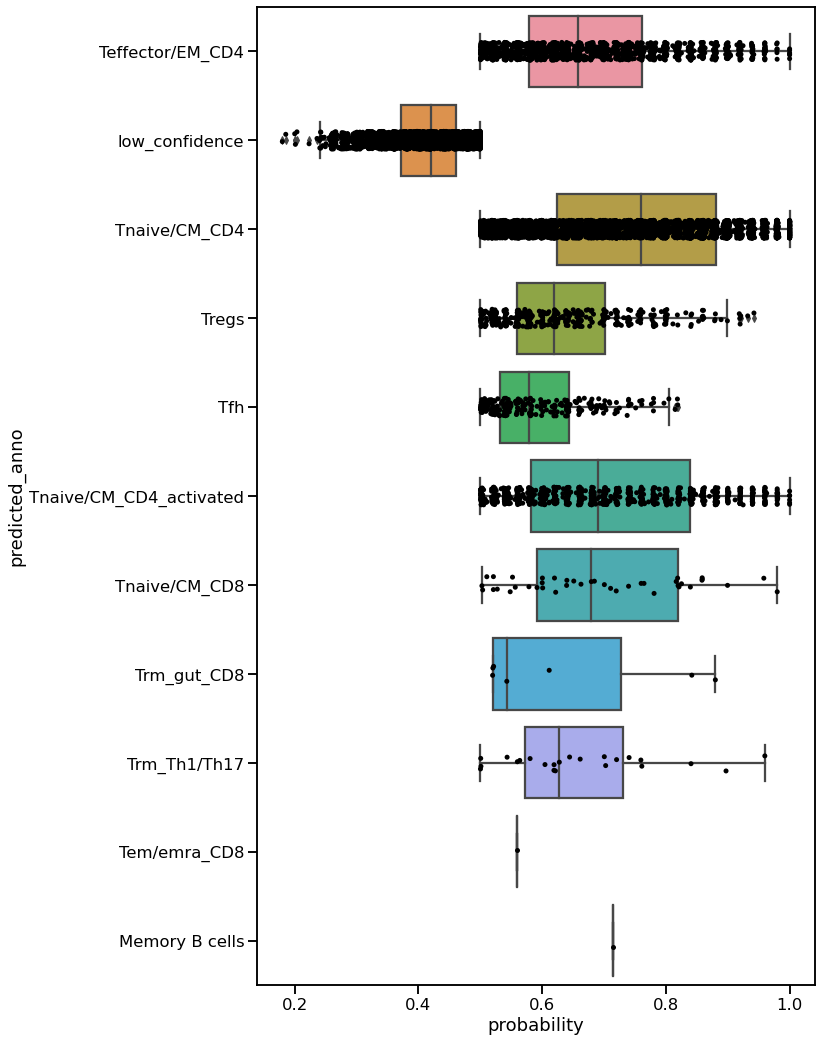

In [98]:
plt.rcParams["figure.figsize"] = [10,18]
map_query_utils.plot_predicted_anno_probability(smp_merged_adata_rev)

In [166]:
smp_merged_adata_rev.obs.loc[smp_merged_adata_rev.obs['predicted_anno_prob'] < 0.8, 'predicted_anno'] = 'low_confidence'

In [167]:
sns.set_context("talk")
query_anno_col="annotation_reference"

query_obs = smp_merged_adata_rev.obs_names[smp_merged_adata_rev.obs.dataset == "query"]
empty_query = query_obs[smp_merged_adata_rev[query_obs].obs[query_anno_col]=="nan"]
merged_adata_clean = smp_merged_adata_rev[~smp_merged_adata_rev.obs_names.isin(empty_query)].copy()
merged_adata_clean.obs[query_anno_col] = merged_adata_clean.obs[query_anno_col].astype("str")

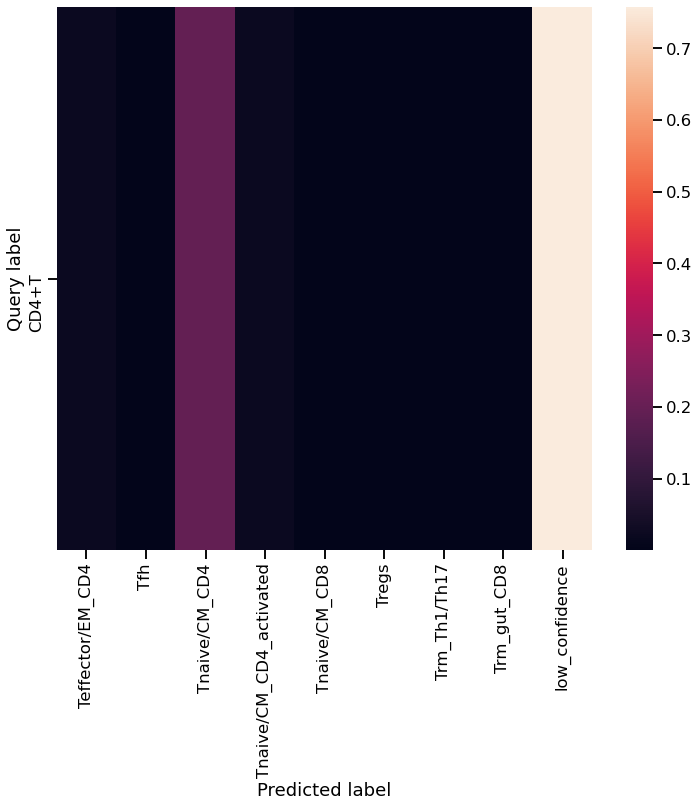

In [168]:
plt.rcParams["figure.figsize"] = [12,10]
map_query_utils.plot_confusion_mat(merged_adata_clean, query_anno_col=query_anno_col, show_low_confidence=True)

In [184]:
df = merged_adata_clean.obs[['predicted_anno', query_anno_col, 'organ', 'predicted_anno_prob']].copy()
df = df[(df[query_anno_col] == 'CD4+T')]
df.predicted_anno.isna()
df.organ = df.organ.astype("str")

keep_organs = df.organ.value_counts().index[df.organ.value_counts() > 10]
df = df[df.organ.isin(keep_organs)].copy()
pl_df = df.groupby(['organ', 'predicted_anno']).size().reset_index()
pl_df.columns = ['organ', 'predicted_anno', 'n_cells']


── Column specification ────────────────────────────────────────────────────────
cols(
  organ = col_character(),
  color = col_character()
)



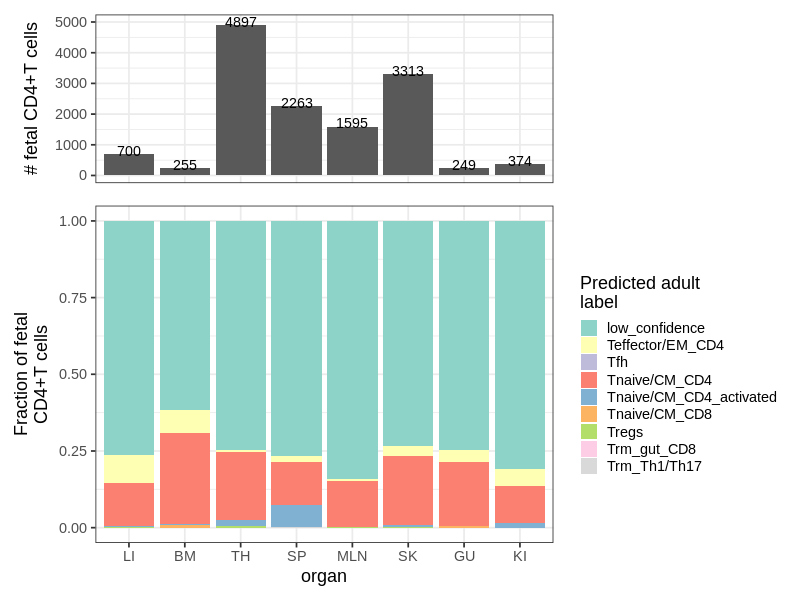

In [185]:
%%R -i pl_df -w 800 -h 600
org_colors <- read_csv('../../metadata/organ_colors.csv')

pl2 <- pl_df %>%
    mutate(organ=factor(organ, levels=c("YS"  ,"LI"  ,"BM"  ,"TH"  ,"SP"  ,"MLN" ,"SK"  ,"GU" ,"KI" ))) %>%
    ggplot(aes(organ, n_cells, fill=predicted_anno) ) +
    geom_col(position='fill') +
    theme_bw(base_size=18) +
    scale_fill_brewer(palette='Set3', name='Predicted adult\nlabel') +
    ylab("Fraction of fetal\nCD4+T cells")

pl1 <- pl_df %>%
    mutate(organ=factor(organ, levels=c("YS"  ,"LI"  ,"BM"  ,"TH"  ,"SP"  ,"MLN" ,"SK"  ,"GU" ,"KI" ))) %>%
    ggplot(aes(organ, n_cells) ) +
    geom_col() +
    geom_text(data =. %>% group_by(organ) %>% summarise(n_cells=sum(n_cells)), aes(label=n_cells), nudge_y=100, size=5) +
    theme_bw(base_size=18) +
    ylab("# fetal CD4+T cells")

((pl1 + remove_x_axis())/ pl2) + plot_layout(heights=c(1,2)) +
ggsave(paste0(figdir, 'CD4T_fetal_prediction.pdf'), width=9, height=7)

In [181]:
df = merged_adata_clean.obs[['predicted_anno', query_anno_col, 'organ', 'predicted_anno_prob']]
df = df[(df['predicted_anno'] == 'Teffector/EM_CD4') & (df[query_anno_col] == 'CD4+T')]
df = df[df.organ.isin(keep_organs)].copy()

In [190]:
sc.pp.normalize_per_cell(merged_adata_clean, counts_per_cell_after=10e04)
sc.pp.log1p(merged_adata_clean)

Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'annotation_reference' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'predicted_anno_unfiltered' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'predicted_anno' as categorical


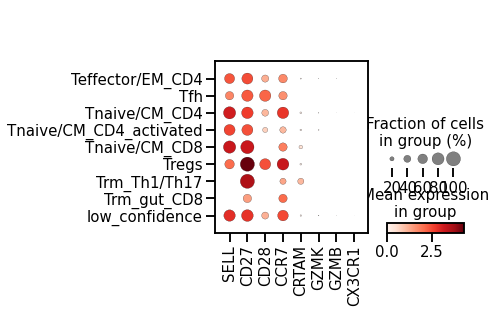

In [211]:
# fig, ax0 = plt.subplots(1,1)
em_markers = {
 'SELL':'ENSG00000188404', 
 'CD27':'ENSG00000139193', 
 "CD28":'ENSG00000178562',
    'CCR7':'ENSG00000126353',
    'CRTAM':'ENSG00000109943',
    'GZMK':'ENSG00000113088',
    'GZMB':'ENSG00000100453',
    'CX3CR1':'ENSG00000168329'
}

axs = sc.pl.dotplot(merged_adata_clean[merged_adata_clean.obs['dataset'] == 'query'], 
              list(em_markers.values()), 
              groupby='predicted_anno', show=False)
axs['mainplot_ax'].set_xticklabels(em_markers.keys())
plt.tight_layout()
plt.savefig(figdir+'EM_markers.pdf')

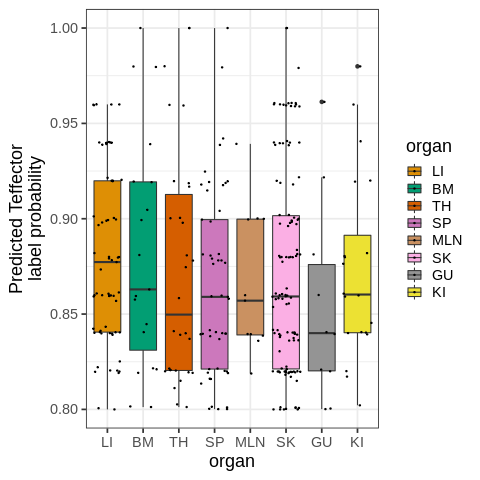

In [183]:
%%R -i df
org_palette <- setNames(org_colors$color, org_colors$organ)

df %>%
    
    mutate(organ=factor(organ, levels=org_colors$organ)) %>%
    ggplot(aes(organ, predicted_anno_prob, fill=organ) ) +
    geom_boxplot() +
    geom_jitter(size=0.5) +
    scale_fill_manual(values=org_palette) +
    theme_bw(base_size=18) +
    ylab("Predicted Teffector\nlabel probability") +
    ggsave(paste0(figdir, 'CD4T_TE_prediction_prob.pdf'), width=9, height=7)
# #     facet_wrap(organ~., scales='free_y')

### Save outputs

In [12]:
# merged_adata.obs['min_distance2pred'] = merged_adata.obs['min_distance2pred'].astype('float')
# merged_adata.write_h5ad(data_dir + merged_adata_file)
# merged_adata = sc.read_h5ad(data_dir + merged_adata_file)

In [112]:
data_dir

'/nfs/team205/ed6/data/Fetal_immune/'

In [121]:
pi_adata = sc.read_h5ad('/nfs/team205/cx1/Celltypist/revision_science/data/PIP_global_object_raw_count.h5ad', backed='r')
adata_fetal = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_normalised_log.20210429.h5ad', backed='r')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Mapping validation metrics

In [17]:
query_mapped_adata = merged_adata[merged_adata.obs['dataset'] == 'query'].copy()

sc.pp.neighbors(query_mapped_adata, use_rep='X_scvi', n_neighbors=30)

In [22]:
query_mapped_adata

AnnData object with n_obs × n_vars = 264929 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'organ_code', 'donor', 'method', 'Category', 'bbk', 'dataset', 'annotation_reference', 'organ', 'age', 'annotation_query', 'leiden'
    uns: '_scvi', 'neighbors', 'umap', 'leiden'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [58]:
sc.tl.leiden(query_mapped_adata, resolution=1)

In [59]:
query_mapped_adata.obs['leiden'] = query_mapped_adata.obs['leiden'].astype("str")
query_mapped_adata.obs['annotation_query'] = query_mapped_adata.obs['annotation_query'].astype("str")

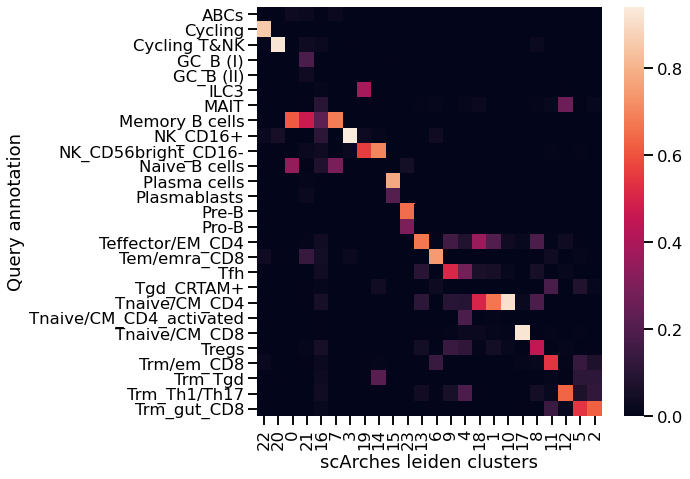

In [60]:
sns.set_context("talk")
keep_cts = query_mapped_adata.obs['annotation_query'].value_counts().index[query_mapped_adata.obs['annotation_query'].value_counts() > 10]
keep_cts = keep_cts[keep_cts!='nan']
conf_mat = sc.metrics.confusion_matrix('leiden','annotation_query', 
                                       query_mapped_adata.obs[query_mapped_adata.obs['annotation_query'].isin(keep_cts)]).T

col_order = conf_mat.idxmax(0).sort_values().index
conf_mat = conf_mat[col_order] ## Sort to have some sort of diagonal

plt.rcParams['figure.figsize'] = [10, 7]
sns.heatmap(conf_mat, xticklabels=True, yticklabels=True);
plt.xlabel("scArches leiden clusters");
plt.ylabel("Query annotation");
plt.tight_layout();
plt.savefig(figdir + 'validation_conf_mat.pdf')

In [27]:
pip_data = sc.read_h5ad('/nfs/team205/cx1/Celltypist/revision_science/data/PIP_global_object.h5ad', backed='r')

In [52]:
query_mapped_adata.obs['leiden_old'] = pip_data.obs.loc[query_mapped_adata.obs_names.str.strip("-query"), 'leiden'].values
query_mapped_adata.obs['batch'] = pip_data.obs.loc[query_mapped_adata.obs_names.str.strip("-query"), 'donor_id'].values

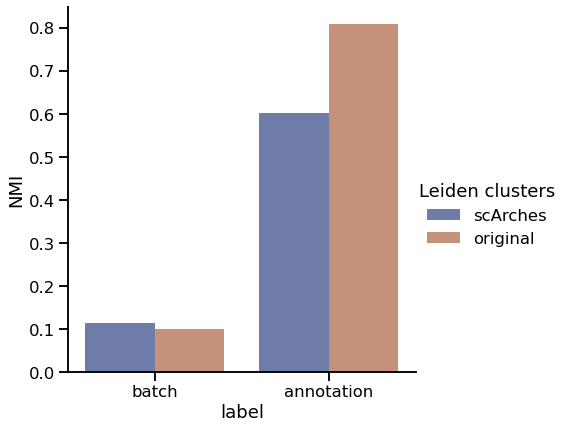

In [61]:
import sklearn
nmi_anno_old = sklearn.metrics.normalized_mutual_info_score(query_mapped_adata.obs['annotation_query'], query_mapped_adata.obs["leiden_old"])
nmi_anno_new = sklearn.metrics.normalized_mutual_info_score(query_mapped_adata.obs['annotation_query'], query_mapped_adata.obs["leiden"])
nmi_batch_old = sklearn.metrics.normalized_mutual_info_score(query_mapped_adata.obs['batch'], query_mapped_adata.obs["leiden_old"])
nmi_batch_new = sklearn.metrics.normalized_mutual_info_score(query_mapped_adata.obs['batch'], query_mapped_adata.obs["leiden"])

df = pd.DataFrame([nmi_batch_new, nmi_batch_old,nmi_anno_new, nmi_anno_old])
df.columns = ['NMI']
df['cat'] = ['batch_scArches', 'batch_original', 'annotation_scArches', "annotation_original"]
df['Leiden clusters'] = [x[1] for x in df['cat'].str.split("_")]
df['label'] = [x[0] for x in df['cat'].str.split("_")]

sns.catplot(
    data=df, kind="bar",
    x="label", y="NMI", hue='Leiden clusters',
    ci="sd", palette="dark", alpha=.6, height=6
)
plt.savefig(figdir + 'validation_barplot.pdf')